In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

#### Clean dataset from any NaNs

In [2]:
df = pd.read_csv('Boats_Cleaned_dataset.csv')
df_cleaned = df.replace(0,np.nan).dropna(axis=0,how='any')
df_cleaned.head(3)

,Unnamed: 0,id,type,boatClass,make,model,year,condition,length_ft,beam_ft,...,minEngineYear,engineCategory,price,sellerId,city,state,zip,created_date,created_month,created_year
1,3,7228300,power,power-sportcruiser,Formula,400 Super Sport,2018,used,40.0,11.00,...,2018.0,inboard-outboard,539000.0,44260,Harsens Island,MI,48028,2019-09-24,9,2019
2,5,7271336,power,power-deck,Bayliner,Element 180,2020,new,18.0,7.42,...,2019.0,outboard-4s,26995.0,220570,Marietta,OH,45750,2019-11-02,11,2019
4,8,6824832,power,power-aft,Carver,440 Aft Cabin Motor Yacht,1994,used,44.0,15.00,...,1994.0,inboard,109900.0,17942,Middle River,MD,21220,2018-08-29,8,2018


#### Dropping id, price (target), sellerId, id, unnamed, minEngineYear, maxEngineYear, zip and city (focusing on state for now, created_date (seeing how just the year and month perform)

#### Splitting data for train/test

In [3]:
(df_train, df_test) = train_test_split(df_cleaned,train_size=0.8,random_state=0)

X_train = df_train.drop(['Unnamed: 0', 'id', 'minEngineYear', 'maxEngineYear', 'price', 
             'sellerId', 'zip', 'city', 'created_date', 
                         'engineCategory', 'boatClass','hullMaterial', 'state'], axis=1)
y_train = df_train.price

X_test = df_test.drop(['Unnamed: 0', 'id', 'minEngineYear', 'maxEngineYear', 'price', 
             'sellerId', 'zip', 'city', 'created_date', 
                       'engineCategory', 'boatClass',  'hullMaterial', 'state'], axis=1)
y_test = df_test.price

print(X_train.shape)
X_train.head(3)

(774, 13)


,type,make,model,year,condition,length_ft,beam_ft,dryWeight_lb,fuelType,numEngines,totalHP,created_month,created_year
12613,power,Ribjet,10,2019,new,10.00,5.33,550.0,gasoline,1.0,60.0,8,2015
13252,power,Nitro,Z17,2019,new,17.33,7.50,1450.0,gasoline,1.0,115.0,1,2019
13195,power,Mako,414 CC,2019,new,41.00,11.92,16840.0,gasoline,4.0,1400.0,8,2018


In [4]:
X_train_num = X_train.select_dtypes(include='number')
X_train_cat = X_train.select_dtypes(exclude='number')

X_test_num = X_test.select_dtypes(include='number')
X_test_cat = X_test.select_dtypes(exclude='number')

stnd = StandardScaler().set_output(transform='pandas')
X_train_num = stnd.fit_transform(X_train_num)
X_test_num = stnd.transform(X_test_num)

X_train_cat = pd.get_dummies(X_train_cat,drop_first=False)
X_test_cat = pd.get_dummies(X_test_cat,drop_first=False)

X_train = pd.concat([X_train_num, X_train_cat],axis=1)
X_test = pd.concat([X_test_num, X_test_cat],axis=1)

X_train.head(3)

,year,length_ft,beam_ft,dryWeight_lb,numEngines,totalHP,created_month,created_year,type_power,type_sail,...,model_ZV19 Pro,model_ZV19 Sport,model_ZV19 Sport Pro,model_ZV21 Pro,model_r272,condition_new,condition_used,fuelType_diesel,fuelType_gasoline,fuelType_other
12613,0.765352,-1.799301,-1.275208,-0.636995,-0.687461,-0.931173,0.630228,-3.578514,True,False,...,False,False,False,False,False,True,False,False,True,False
13252,0.765352,-1.086281,-0.664662,-0.578726,-0.687461,-0.806202,-1.454372,0.730735,True,False,...,False,False,False,False,False,True,False,False,True,False
13195,0.765352,1.216199,0.578939,0.417671,3.168299,2.113564,0.630228,-0.346577,True,False,...,False,False,False,False,False,True,False,False,True,False


## Ridge Regression


best alpha = {'alpha': 0.1}    valid R2 = 0.711


model_54                -404676.950270
model_70 Motor Yacht    -377731.418876
make_Ocean Yachts       -371192.788087
model_63 Motoryacht     -326297.484891
model_61 Motoryacht     -230761.983797
                             ...      
model_630 Sport Yacht    471187.225464
model_520 Flybridge      557462.567249
make_Queenship           564211.727088
model_74 RPH             564211.727088
model_60 Motor Yacht     966302.329635
Length: 826, dtype: float64

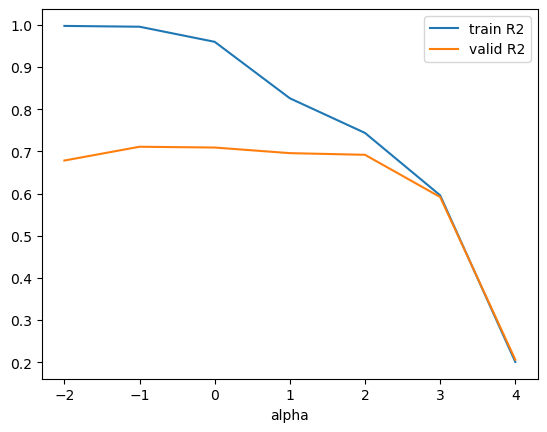

In [5]:
grid = {'alpha':[0.01,0.1,1,10,100,1000,10000]}
ridge = Ridge()
ridgeCV = GridSearchCV(ridge,param_grid=grid,return_train_score=True)
ridgeCV.fit(X_train,y_train)

print()
print('best alpha =',ridgeCV.best_params_, '   valid R2 =',ridgeCV.best_score_.round(3))

results = pd.DataFrame()
results['alpha'] = np.log10(grid['alpha'])
results['train R2'] = ridgeCV.cv_results_['mean_train_score']
results['valid R2']  = ridgeCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='alpha',y='train R2')
results.plot.line(x='alpha',y='valid R2',ax=ax1)

ridge = ridgeCV.best_estimator_
coef = pd.Series(ridge.coef_,index=X_train.columns)
coef.sort_values()

## Lasso Regression

/opt/miniforge3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.944e+10, tolerance: 3.166e+09
  model = cd_fast.enet_coordinate_descent(
/opt/miniforge3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.447e+10, tolerance: 3.273e+09
  model = cd_fast.enet_coordinate_descent(
/opt/miniforge3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.336e+10, to


best alpha = {'alpha': 100}   valid R2 = 0.703


model_R222 Center Console   -2.072362e+05
model_54                    -2.004587e+05
make_Ocean Yachts           -1.710619e+05
make_Italia                 -1.280795e+05
model_480 Sedan Bridge      -1.030975e+05
                                 ...     
model_630 Sport Yacht        6.424072e+05
model_520 Flybridge          7.349889e+05
make_Garlington              1.202869e+06
model_60 Motor Yacht         1.240380e+06
make_Queenship               1.428860e+06
Length: 826, dtype: float64

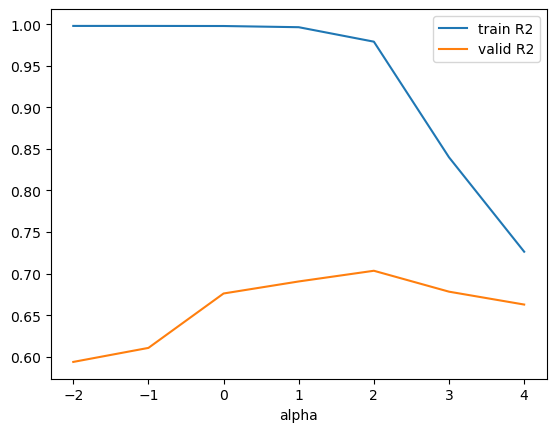

In [6]:
grid = {'alpha':[0.01,0.1,1,10,100,1000,10000]}
lasso = Lasso()
lassoCV = GridSearchCV(lasso,param_grid=grid,return_train_score=True)
lassoCV.fit(X_train,y_train)

print()
print('best alpha =',lassoCV.best_params_, '  valid R2 =',lassoCV.best_score_.round(3))

results = pd.DataFrame()
results['alpha'] = np.log10(grid['alpha'])
results['train R2'] = lassoCV.cv_results_['mean_train_score']
results['valid R2']  = lassoCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='alpha',y='train R2')
results.plot.line(x='alpha',y='valid R2',ax=ax1)

lasso = lassoCV.best_estimator_
coef = pd.Series(lasso.coef_,index=X_train.columns)
coef.sort_values()

Train R2 is far too high compared to validation, most likely overfitting here